In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

pd.set_option("mode.copy_on_write", True)

In [2]:
# Load cleaned merged dataset(population, mortality, ARCOS).
final_merged = pd.read_csv(r"C:\Users\rmous\Downloads\final_merged.csv")
final_merged.head()

,State,County,Total_MME,County.1,County Code,Drug/Alcohol Induced Cause,Drug/Alcohol Induced Cause Code,Deaths,year,Population
0,GA,APPLING,5201.267675,"Appling County, GA",13001,All other non-drug and non-alcohol causes,O9,215,2015,18423
1,GA,ATKINSON,1023.390277,"Atkinson County, GA",13003,All other non-drug and non-alcohol causes,O9,81,2015,8340
2,GA,BACON,3824.818008,"Bacon County, GA",13005,All other non-drug and non-alcohol causes,O9,133,2015,11231
3,GA,BALDWIN,7352.035690,"Baldwin County, GA",13009,All other non-drug and non-alcohol causes,O9,424,2015,45549
4,GA,BANKS,2115.657581,"Banks County, GA",13011,All other non-drug and non-alcohol causes,O9,183,2015,18381


In [3]:
final_merged.columns

Index(['State', 'County', 'Total_MME', 'County.1', 'County Code',
       'Drug/Alcohol Induced Cause', 'Drug/Alcohol Induced Cause Code',
       'Deaths', 'year', 'Population'],
      dtype='object')

## Parallel trend check for overdose rate ##

In [4]:
# Build panel for selected states and pre-treatment years (2007-2010)
states = ["FL", "NC", "SC", "GA"]

df_fl_panel = final_merged[
    (final_merged["State"].isin(states))
    & (final_merged["year"] >= 2007)
    & (final_merged["year"] <= 2010)
][
    [
        "County Code",
        "State",
        "County",
        "year",
        "Population",
        "Drug/Alcohol Induced Cause",
        "Deaths",
    ]
].copy()

In [5]:
df_fl_panel

,County Code,State,County,year,Population,Drug/Alcohol Induced Cause,Deaths
6466,13001,GA,APPLING,2007,17985,All other non-drug and non-alcohol causes,176
6467,13001,GA,APPLING,2008,18133,All other non-drug and non-alcohol causes,192
6468,13001,GA,APPLING,2009,18144,All other non-drug and non-alcohol causes,178
6469,13001,GA,APPLING,2010,18261,All other non-drug and non-alcohol causes,204
6470,13001,GA,APPLING,2010,18334,All other non-drug and non-alcohol causes,204
...,...,...,...,...,...,...,...
261402,45091,SC,YORK,2010,226865,Drug poisonings (overdose) Unintentional (X40-...,24
261403,45091,SC,YORK,2010,226971,All other alcohol-induced causes,11
261404,45091,SC,YORK,2010,226865,All other alcohol-induced causes,11
261405,45091,SC,YORK,2010,226971,All other non-drug and non-alcohol causes,1674


In [6]:
# Compute overdose rate per 100,000 so counties are comparable by population

df_fl_panel["overdose_rate"] = (
    df_fl_panel["Deaths"] / df_fl_panel["Population"] * 100000
)

In [7]:
# Create treated indicator (Florida=1)

df_fl_panel["treated"] = (df_fl_panel["State"] == "FL").astype(int)

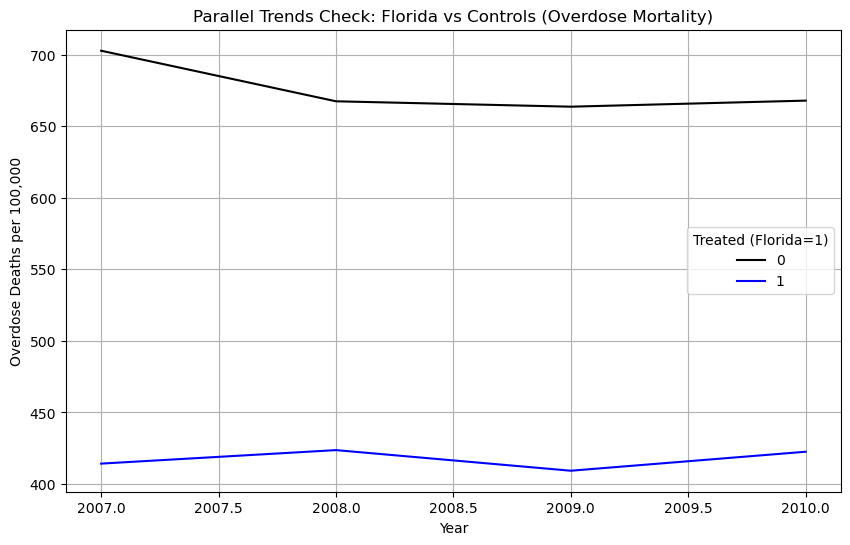

In [8]:
# Plot parallel trends: compare treated vs controls visually to inspect pre-treatment trends
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_fl_panel,
    x="year",
    y="overdose_rate",
    hue="treated",
    palette={1: "blue", 0: "black"},
    errorbar=None,
)

plt.title("Parallel Trends Check: Florida vs Controls (Overdose Mortality)")
plt.xlabel("Year")
plt.ylabel("Overdose Deaths per 100,000")
plt.legend(title="Treated (Florida=1)")
plt.grid(True)

plt.show()

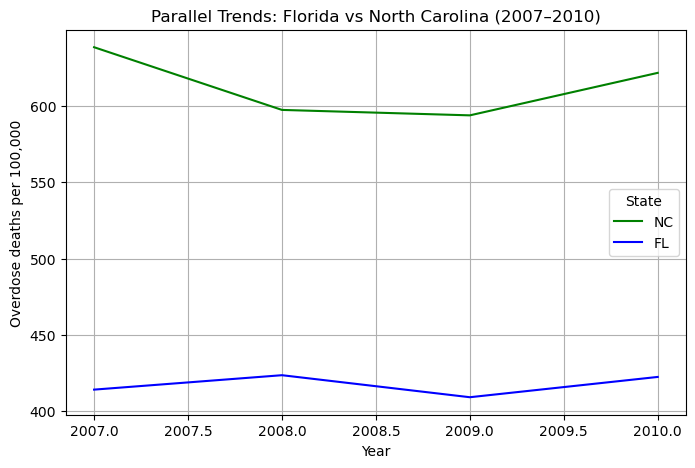

In [9]:
# Florida vs North Carolina
states_nc = ["FL", "NC"]

df_nc = df_fl_panel[df_fl_panel["State"].isin(states_nc)].copy()

plt.figure(figsize=(8, 5))

sns.lineplot(
    data=df_nc,
    x="year",
    y="overdose_rate",
    hue="State",
    palette={"FL": "blue", "NC": "green"},
    errorbar=None,
)

plt.title("Parallel Trends: Florida vs North Carolina (2007–2010)")
plt.xlabel("Year")
plt.ylabel("Overdose deaths per 100,000")
plt.grid(True)
plt.legend(title="State")
plt.show()

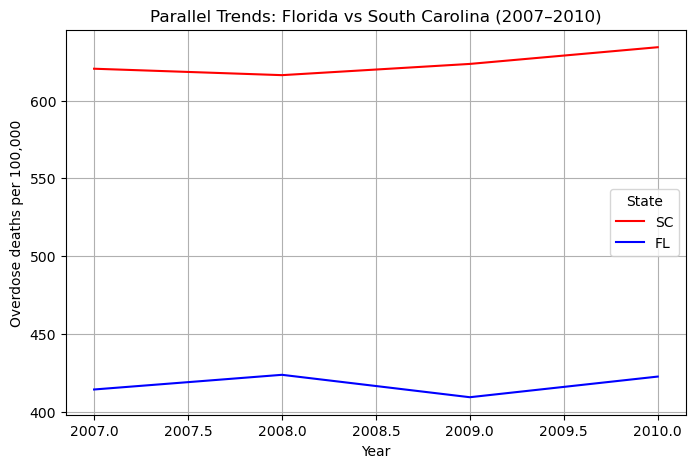

In [10]:
# Florida vs South Carolina
states_sc = ["FL", "SC"]

df_sc = df_fl_panel[df_fl_panel["State"].isin(states_sc)].copy()

plt.figure(figsize=(8, 5))

sns.lineplot(
    data=df_sc,
    x="year",
    y="overdose_rate",
    hue="State",
    palette={"FL": "blue", "SC": "red"},
    errorbar=None,
)

plt.title("Parallel Trends: Florida vs South Carolina (2007–2010)")
plt.xlabel("Year")
plt.ylabel("Overdose deaths per 100,000")
plt.grid(True)
plt.legend(title="State")
plt.show()

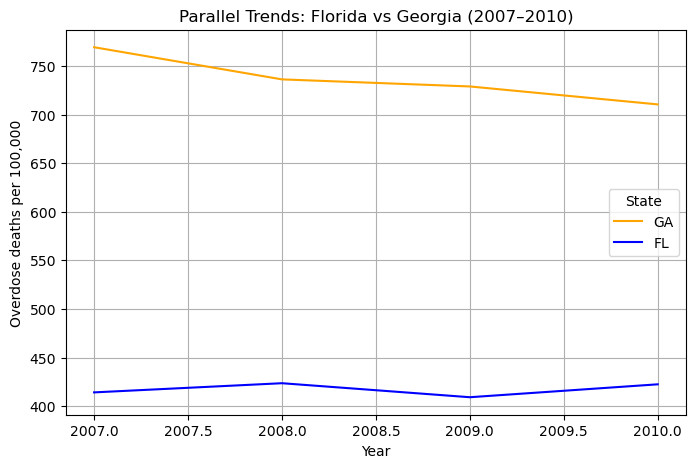

In [11]:
# Florida vs Georgia
states_ga = ["FL", "GA"]

df_ga = df_fl_panel[df_fl_panel["State"].isin(states_ga)].copy()

plt.figure(figsize=(8, 5))

sns.lineplot(
    data=df_ga,
    x="year",
    y="overdose_rate",
    hue="State",
    palette={"FL": "blue", "GA": "orange"},
    errorbar=None,
)

plt.title("Parallel Trends: Florida vs Georgia (2007–2010)")
plt.xlabel("Year")
plt.ylabel("Overdose deaths per 100,000")
plt.grid(True)
plt.legend(title="State")
plt.show()

In [12]:
# Fit a simple OLS: interaction term tests for different time slope in treated units
model = smf.ols(formula="overdose_rate ~ treated * year", data=df_fl_panel).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          overdose_rate   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2641.
Date:                Sat, 29 Nov 2025   Prob (F-statistic):               0.00
Time:                        17:26:55   Log-Likelihood:            -8.5995e+05
No. Observations:              113436   AIC:                         1.720e+06
Df Residuals:                  113432   BIC:                         1.720e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.902e+04   3154.067      6.032   

Because the p‑value is well above 0.05, we fail to reject the hypothesis of no difference in pre‑treatment trends. Therefore, the trends in Georgia, North Carolina, and South Carolina are reasonably parallel to Florida’s over 2006–2009, and these states can be used as control groups in the DiD design.

## Parallel trend check for opioid per capita ##

In [13]:
# Create opioid-per-capita variable (Total MME / Population) for parallel-trend checks
final_merged["opioid_per_capita"] = (
    final_merged["Total_MME"] / final_merged["Population"]
)

In [14]:
# Build panel for opioid per-capita analysis (same states/years as mortality check)

df_opioid = final_merged[
    (final_merged["State"].isin(states))
    & (final_merged["year"] >= 2007)
    & (final_merged["year"] <= 2010)
][["County Code", "State", "County", "year", "Population", "Total_MME"]].copy()

In [15]:
# Compute opioid shipments per capita to normalize by population
# This makes comparisons across counties meaningful

df_opioid["opioid_per_capita"] = df_opioid["Total_MME"] / df_opioid["Population"]

In [16]:
# Create treated indicator (Florida=1)
# Same treated definition as in the mortality analysis

df_opioid["treated"] = (df_opioid["State"] == "FL").astype(int)

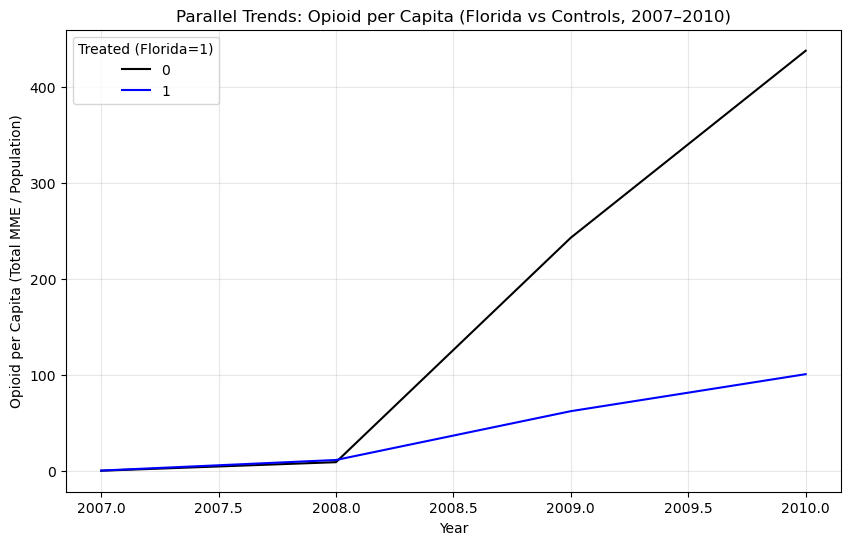

In [17]:
# Plot opioid-per-capita parallel trends (treated vs controls) to inspect pre-treatment similarity
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_opioid,
    x="year",
    y="opioid_per_capita",
    hue="treated",
    estimator="mean",
    errorbar=None,
    palette={1: "blue", 0: "black"},
)

plt.title("Parallel Trends: Opioid per Capita (Florida vs Controls, 2007–2010)")
plt.xlabel("Year")
plt.ylabel("Opioid per Capita (Total MME / Population)")
plt.grid(True, alpha=0.3)
plt.legend(title="Treated (Florida=1)")
plt.show()

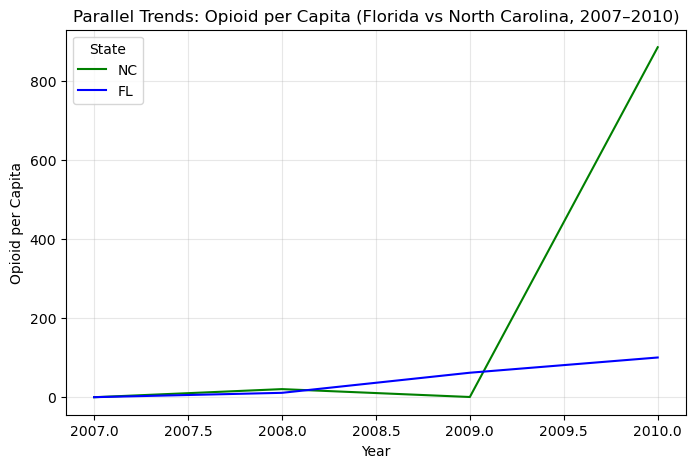

In [ ]:
# Plot opioid per-capita: Florida vs North Carolina (mean per year)
states_nc = ["FL", "NC"]
df_nc = df_opioid[df_opioid["State"].isin(states_nc)].copy()

plt.figure(figsize=(8, 5))

sns.lineplot(
    data=df_nc,
    x="year",
    y="opioid_per_capita",
    hue="State",
    estimator="mean",
    errorbar=None,
    palette={"FL": "blue", "NC": "green"},
)

plt.title("Parallel Trends: Opioid per Capita (Florida vs North Carolina, 2007–2010)")
plt.xlabel("Year")
plt.ylabel("Opioid per Capita")
plt.grid(True, alpha=0.3)
plt.legend(title="State")
plt.show()

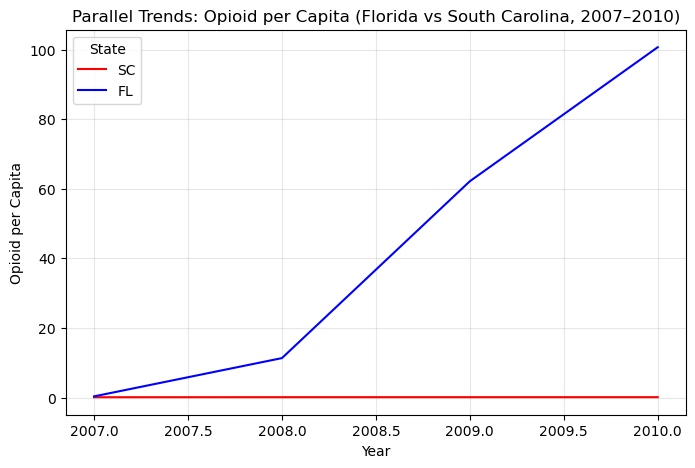

In [19]:
# Plot opioid per-capita: Florida vs South Carolina (mean per year)
states_sc = ["FL", "SC"]
df_sc = df_opioid[df_opioid["State"].isin(states_sc)].copy()

plt.figure(figsize=(8, 5))

sns.lineplot(
    data=df_sc,
    x="year",
    y="opioid_per_capita",
    hue="State",
    estimator="mean",
    errorbar=None,
    palette={"FL": "blue", "SC": "red"},  # Florida  # South Carolina
)

plt.title("Parallel Trends: Opioid per Capita (Florida vs South Carolina, 2007–2010)")
plt.xlabel("Year")
plt.ylabel("Opioid per Capita")
plt.grid(True, alpha=0.3)
plt.legend(title="State")
plt.show()

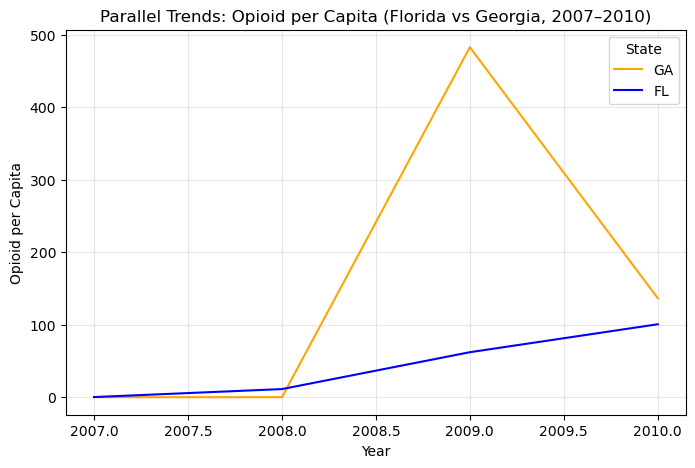

In [ ]:
# Plot opioid per-capita: Florida vs Georgia (mean per year)
states_ga = ["FL", "GA"]
df_ga = df_opioid[df_opioid["State"].isin(states_ga)].copy()

plt.figure(figsize=(8, 5))

sns.lineplot(
    data=df_ga,
    x="year",
    y="opioid_per_capita",
    hue="State",
    estimator="mean",
    errorbar=None,
    palette={"FL": "blue", "GA": "orange"},
)

plt.title("Parallel Trends: Opioid per Capita (Florida vs Georgia, 2007–2010)")
plt.xlabel("Year")
plt.ylabel("Opioid per Capita")
plt.grid(True, alpha=0.3)
plt.legend(title="State")
plt.show()

In [21]:
# Fit a simple OLS for opioid per capita; interaction tests for differing pre-trends
model_opioid = smf.ols(
    formula="opioid_per_capita ~ treated * year", data=df_opioid
).fit()

print(model_opioid.summary())

                            OLS Regression Results                            
Dep. Variable:      opioid_per_capita   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     8.627
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           1.01e-05
Time:                        17:26:57   Log-Likelihood:            -1.2189e+06
No. Observations:              113436   AIC:                         2.438e+06
Df Residuals:                  113432   BIC:                         2.438e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -3.238e+05   7.47e+04     -4.335   

The p-value is less than 0.05, providing evidence to reject the hypothesis of parallel pre-treatment trends. Therefore, opioid-per-capita trends in Georgia, North Carolina, and South Carolina are statistically different from Florida’s over 2006–2009. Because of these divergent pre-policy trends, using these three states as controls would make the DiD results for this prescribing outcome substantially less reliable and should be interpreted with caution.

## Final interpretation for parallel trend check for Florida's policy

Our parallel trends diagnostics produced different results for the two outcomes. For overdose mortality, the pre-policy regression showed that the interaction term between treated and year was not statistically significant (p-value > 0.05). This indicates that Florida and the selected control states (GA, NC, SC) followed similar pre-policy trends in overdose mortality from 2007 to 2010. Therefore, the parallel trends assumption is reasonably supported for this outcome, and we can be more confident in the validity of the subsequent DiD estimates for mortality.

In contrast, when we repeated the same analysis for opioid consumption (opioid per capita), the interaction term was highly statistically significant (p-value < 0.05). This suggests that Florida’s pre-policy trend in opioid shipments differed substantially from the control states. As a result, the parallel trends assumption does not hold for opioid per capita, implying that our DiD estimates for prescribing behavior should be interpreted with greater caution, as they may not fully isolate the causal effect of the 2010 Florida policy.